# Newsgroup20 Classification

In [31]:
import itertools
import scipy
import numpy as np
import pandas as pd
import logging

import helper
import gensim
from gensim.models import word2vec, doc2vec

import sklearn
from sklearn import metrics
from sklearn.linear_model import SGDClassifier, PassiveAggressiveClassifier, Perceptron

import nltk
from nltk.corpus import wordnet as wn
from nltk.stem import PorterStemmer, WordNetLemmatizer

import matplotlib
import matplotlib.pyplot as plt

import bokeh
from bokeh.plotting import figure, output_file, show

In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.INFO)
bokeh.plotting.output_notebook()

Loading BokehJS ...

### Available categories

In [34]:
with open('categories-ng20.txt') as f:
    all_categories = f.read().split()
', '.join(all_categories)

'comp.graphics, comp.os.ms-windows.misc, comp.sys.ibm.pc.hardware, comp.sys.mac.hardware, comp.windows.x, rec.autos, rec.motorcycles, rec.sport.baseball, rec.sport.hockey, sci.crypt, sci.electronics, sci.med, sci.space, misc.forsale, talk.politics.misc, talk.politics.guns, talk.politics.mideast, talk.religion.misc, alt.atheism, soc.religion.christian'

### Fetch subset of newsgroup-20 dataset

In [35]:
REMOVE = ('headers', 'footers', 'quotes')
CATEGORIES = ('talk.politics.misc', 'comp.graphics', 'sci.space')
CATEGORIES = None

newsgroup_dataset_train = sklearn.datasets.fetch_20newsgroups(subset = 'train', remove = REMOVE, categories = CATEGORIES)
newsgroup_dataset_test = sklearn.datasets.fetch_20newsgroups(subset = 'test', remove = REMOVE, categories = CATEGORIES)

## Training classifiers on vectorized docs

### Feature extraction
Remove stopwords and vectorize with Tfidf

In [36]:
vectorizer = sklearn.feature_extraction.text.CountVectorizer(stop_words = 'english')
vectorizer.fit(newsgroup_dataset_train.data)

vectors_train = vectorizer.transform(newsgroup_dataset_train.data)
vectors_test = vectorizer.transform(newsgroup_dataset_test.data)

tfidf_transformer = sklearn.feature_extraction.text.TfidfTransformer()
tfidf_transformer.fit(vectors_train)
vectors_trans_train = tfidf_transformer.transform(vectors_train)
vectors_trans_test = tfidf_transformer.transform(vectors_test)

### MostFrequentLabelClassifer
Always predicts the most-frequent label

In [37]:
df_train = pd.DataFrame(newsgroup_dataset_train.target)
df_train.rename(columns = {0: 'target'}, inplace = True)
most_frequent_class_in_train = round(df_train.target.mean())

class MostFrequentLabelClassifier(object):
     
    def __init__(self, label_to_return):
        self.label_to_return = label_to_return
        
    def fit(self, x = None, y = None):
        pass

    def predict(self, x = None):
        return [self.label_to_return] * x.shape[0]

### Train different classifiers on tfidf vectors of docs

PassiveAggressiveClassifier
Perceptron
MostFrequentLabel


/Users/davidgengenbach/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/davidgengenbach/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LogisticRegression
SGDClassifier


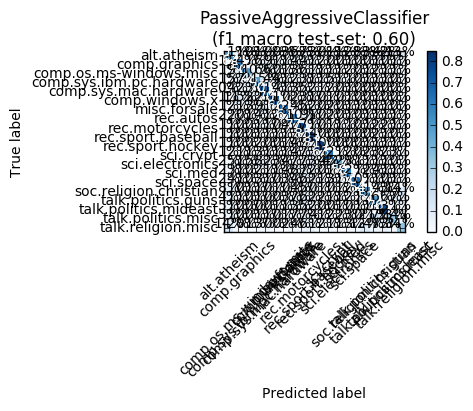

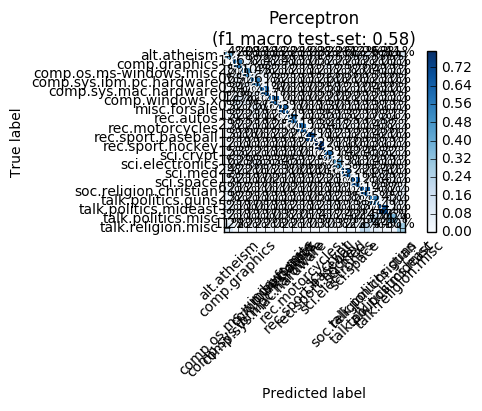

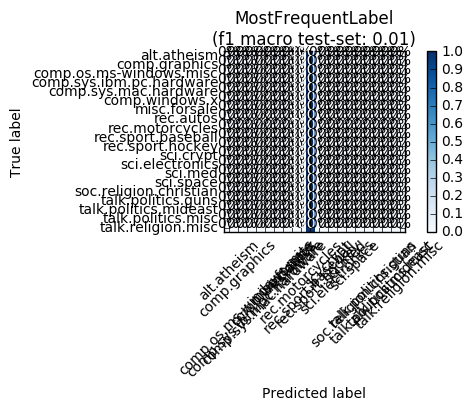

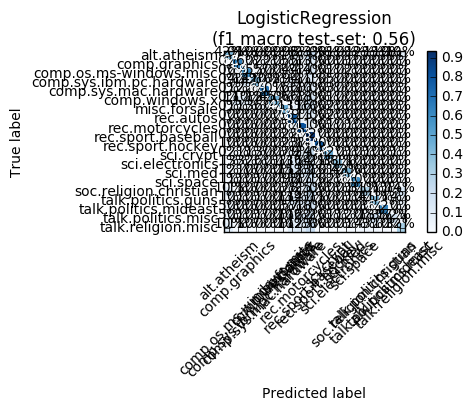

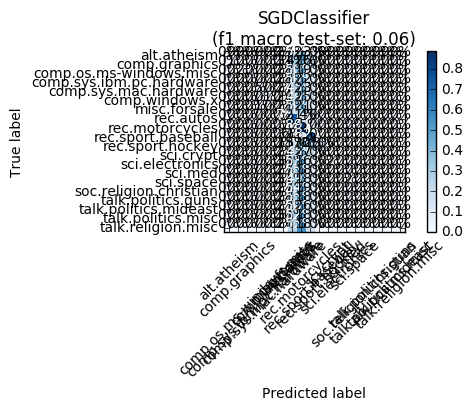

F1 Scores


,LogisticRegression,MostFrequentLabel,PassiveAggressiveClassifier,Perceptron,SGDClassifier
acc,0.546999,0.052708,0.606213,0.587361,0.145247
test,0.556458,0.005007,0.596652,0.579768,0.062757
train,0.952367,0.005012,0.970322,0.970395,0.111951


In [38]:
clfs = {
    'PassiveAggressiveClassifier': sklearn.linear_model.PassiveAggressiveClassifier(),
    'Perceptron': sklearn.linear_model.Perceptron(n_iter = 500),
    'LogisticRegression': sklearn.linear_model.LogisticRegression(max_iter = 500),
    'SGDClassifier': sklearn.linear_model.SGDClassifier(n_iter = 500),
    'MostFrequentLabel': MostFrequentLabelClassifier(most_frequent_class_in_train)
}

results = {}
for clf_name, clf in clfs.items():
    print(clf_name)
    clf.fit(vectors_train, newsgroup_dataset_train.target)
    pred_train = clf.predict(vectors_trans_train)
    pred_test = clf.predict(vectors_trans_test)
    f1_score_train = metrics.f1_score(newsgroup_dataset_train.target, pred_train, average='macro')
    f1_score_test = metrics.f1_score(newsgroup_dataset_test.target, pred_test, average='macro')
    results[clf_name] = {'train': f1_score_train, 'test': f1_score_test, 'acc': metrics.accuracy_score(newsgroup_dataset_test.target, pred_test)}
    confusion_matrix = metrics.confusion_matrix(newsgroup_dataset_test.target, pred_test)
    class_report = metrics.classification_report(newsgroup_dataset_test.target, pred_test, target_names=newsgroup_dataset_test.target_names)
    plt.figure()
    helper.plot_confusion_matrix(confusion_matrix, newsgroup_dataset_test.target_names, title = '{}\n(f1 macro test-set: {:.2f})'.format(clf_name, f1_score_test), normalize = True)
plt.show()

print('F1 Scores')
pd.DataFrame(results)

## Train Doc2Vec and Word2Vec classifier

### Pre-process docs for d2v and w2v

In [ ]:
porter = PorterStemmer()
wnl = WordNetLemmatizer()

def lemmatize(ambiguous_word, pos=None, neverstem=True, 
              lemmatizer=wnl, stemmer=porter):
    """Tries to convert a surface word into lemma, and if lemmatize word is not in
    wordnet then try and convert surface word into its stem.
    This is to handle the case where users input a surface word as an ambiguous 
    word and the surface word is a not a lemma.
    
    Adapted from https://github.com/alvations/pywsd/blob/master/pywsd/utils.py
    """
    if pos:
        lemma = lemmatizer.lemmatize(ambiguous_word, pos=pos)
    else:
        lemma = lemmatizer.lemmatize(ambiguous_word)
    stem = stemmer.stem(ambiguous_word)
    # Ensure that ambiguous word is a lemma.
    if not wn.synsets(lemma):
        if neverstem:
            return ambiguous_word
        if not wn.synsets(stem):
            return ambiguous_word
        else:
            return stem
    else:
        return lemma

LEMMATIZE = False
    
def w2v_preproess(doc):
    return [lemmatize(x.lower()) if LEMMATIZE else x.lower() for x in sklearn.feature_extraction.text.CountVectorizer(stop_words = 'english').build_tokenizer()(doc)]

w2v_data = [w2v_preproess(doc) for doc in newsgroup_dataset_train.data]
w2v_data_test = [w2v_preproess(doc) for doc in newsgroup_dataset_test.data]

### Train Word2Vec

In [ ]:
model_w2v = gensim.models.Word2Vec(w2v_data, iter = 50)

### t-SNE vectors

In [ ]:
# Ignore for now, very time-consuming
if 0 == 1:
    w2v_vectors = model_w2v[model_w2v.wv.vocab]

    tsne = sklearn.manifold.TSNE(n_components=2)
    tsne_vectors = tsne.fit_transform(w2v_vectors)

In [ ]:
indexed_vocab = {v.index: k for k, v in model_w2v.wv.vocab.items()}
indexed_vocab_new = sorted([k for k in indexed_vocab.items()], key = lambda x:x[0])
indexed_vocab_new = [x[1] for x in indexed_vocab_new]

def plot_embedding_plt(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(50, 50), dpi=300)
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(indexed_vocab[i]),
                 fontdict={'size': 20})

    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

def plot_embedding_bokeh(X, width = 1000, height = 1000):
    from bokeh.models import HoverTool
    hover = HoverTool(tooltips = [
            ('Word', '@target'),
            ('index', '$index')
    ])
    
    p = bokeh.plotting.figure(plot_width=width, plot_height=height, tools = [hover, bokeh.models.WheelZoomTool(), bokeh.models.PanTool()])
    df = pd.DataFrame(X, columns=['x', 'y'])
    df['target'] = pd.Series(indexed_vocab_new, index=df.index)

    source = bokeh.plotting.ColumnDataSource(df)
    p.circle(x = df.x, y = df.y, source = source, size=20, color="navy", alpha=0.5)
    return p


if 0 == 1:
    show(plot_embedding_bokeh(tsne_vectors, width = 900, height = 700))
    
    plot_embedding_plt(tsne_vectors)
    plt.savefig('yes.png')


### Train Doc2Vec

In [ ]:
tagged_documents = [gensim.models.doc2vec.TaggedDocument(words = words, tags = [tags]) for words, tags in zip(w2v_data, newsgroup_dataset_train.target)]
model_d2v = gensim.models.Doc2Vec(tagged_documents, size = 1000, iter = 50)

#### Scores for Doc2Vec (f1 macro, confusion matrix, classification report)

In [ ]:
d2v_inferred_train = [model_d2v.infer_vector(x, steps = 10) for x in w2v_data]
d2v_inferred_test = [model_d2v.infer_vector(x, steps = 10) for x in w2v_data_test]

def fit_and_predict_d2v(clf):
    """Fit the given classifier to the train/test data.
    Return predictions.
    """
    clf.fit(model_d2v.docvecs, list(range(len(model_d2v.docvecs))))
    pred_train = clf.predict(np.array(d2v_inferred_train))
    pred_test = clf.predict(np.array(d2v_inferred_test))
    return pred_train, pred_test

In [ ]:
d2v_classification_predictions = {clf_name: fit_and_predict_d2v(clf) for clf_name, clf in clfs.items()}

In [ ]:
results = {}
for clf_name, predictions in d2v_classification_predictions.items():
    pred_train, pred_test = predictions[0], predictions[1]
    f1_score_train = metrics.f1_score(newsgroup_dataset_train.target, pred_train, average='macro')
    f1_score_test = metrics.f1_score(newsgroup_dataset_test.target, pred_test, average='macro')
    confusion_matrix = metrics.confusion_matrix(newsgroup_dataset_test.target, pred_test)
    class_report = metrics.classification_report(newsgroup_dataset_test.target, pred_test, target_names=newsgroup_dataset_test.target_names)
    results[clf_name] = {'train': f1_score_train, 'test': f1_score_test}
    plt.figure()
    helper.plot_confusion_matrix(confusion_matrix, newsgroup_dataset_test.target_names, title = '{}\n(f1 macro test-set: {:.2f})'.format(clf_name, f1_score_test), normalize = True)

### Results doc2vec classifier

In [ ]:
plt.show()
pd.DataFrame(results)